# Redes de deslocamento para acesso ao parto hospitalar no Brasil

## Sobre

- [Fonte dos dados](https://pcdas.icict.fiocruz.br/conjunto-de-dados/sistema-de-informacoes-hospitalares-do-sus-sihsus/)
- [Backup no Google Drive]('https://drive.google.com/uc?id=149l5K6rEXWZ6MhIfSsatSN_Q5Esum7x1')
- [Informações sobre o projeto](https://pcdas.icict.fiocruz.br/rede-de-parcerias/a-distancia-importa-redes-de-deslocamento-para-acesso-ao-parto-hospitalar-no-brasil/)

## Carregando dados

### Bibliotecas

In [1]:
import data_load, data_info, data_plot

### Conjuntos de dados

In [2]:
sihsus, dicio = data_load.load_sihsus()

In [3]:
sihsus

,Arquivo,UF,Ano,Mês,Parto,Linhas,Colunas,Variável,Diferentes
1,AC_2008_01_CESARIANO_103_198.jay,AC,2008,1,CESARIANO,103,198,AREA,18
2,AC_2008_01_CESARIANO_103_198.jay,AC,2008,1,CESARIANO,103,198,coordenadas,18
7,AC_2008_01_CESARIANO_103_198.jay,AC,2008,1,CESARIANO,103,198,LONGITUDE,18
8,AC_2008_01_CESARIANO_103_198.jay,AC,2008,1,CESARIANO,103,198,codigo_adotado,18
9,AC_2008_01_CESARIANO_103_198.jay,AC,2008,1,CESARIANO,103,198,LATITUDE,18
...,...,...,...,...,...,...,...,...,...
11,TO_2021_07_NORMAL_863_221.jay,TO,2021,7,NORMAL,863,221,REGIAO,7
19,TO_2021_07_NORMAL_863_221.jay,TO,2021,7,NORMAL,863,221,AMAZONIA,2
3,TO_2021_07_NORMAL_863_221.jay,TO,2021,7,NORMAL,863,221,ANOEXT,0
16,TO_2021_07_NORMAL_863_221.jay,TO,2021,7,NORMAL,863,221,FRONTEIRA,0


In [4]:
dicio

,Coluna,Tipo,Descrição
0,UF_ZI,int8,Município gestor
1,ANO_CMPT,int8,Ano de processamento da AIH
2,MES_CMPT,text,Mês de processamento da AIH
3,ESPEC,text,Especialidade do leito
4,CGC_HOSP,text,CNPJ do estabelecimento
...,...,...,...
237,ano_saida,int8,Ano de saída
238,dia_semana_saida,text,Dia da semana da saída
239,idade_nascimento_anos,int8,Idade em anos pelo ano de nascimento
240,def_idade_dias,int8,Idade em dias


## Tabelas

As tabelas estão agrupadas por `UF`, `Ano` e `Mês`.

Para visualizarmos a cobertura de tabelas, vamos ver quantos meses estão contemplados para cada `UF`x`Ano`.

### Por Ano x UF

<AxesSubplot:title={'center':'Número de meses por Ano x UF'}, xlabel='UF', ylabel='Ano'>

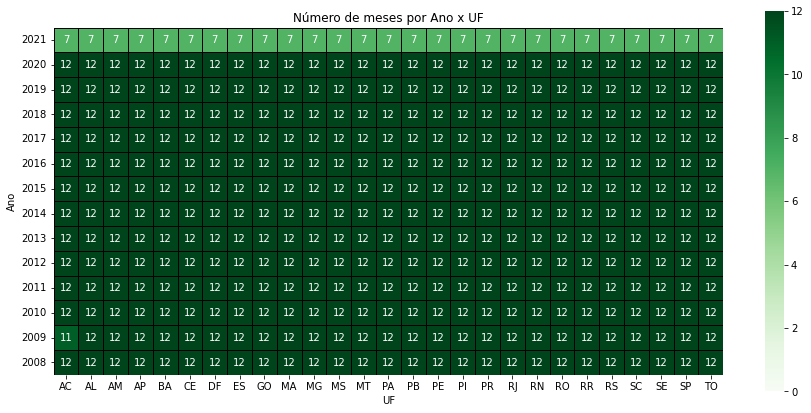

In [5]:
meses_faltantes = data_info.months_per_year_uf(sihsus)
data_plot.heatmap(meses_faltantes, annot=True)

**Comentários:**
- Todas as 27 UFs estão contidas;
- Há cobertura de 2008 até 2021;
- Ano de 2021 está incompleto (indo até o Julho)
- Em 2009 no `AC` faltou 1 mês nos registros;

## Quantidade de Variáveis (Colunas)

A depender do ano, as colunas das tabelas podem ter uma quantidade diferente.

### Por Ano x UF

<AxesSubplot:title={'center':'Número de colunas distintas por Ano x UF'}, xlabel='UF', ylabel='Ano'>

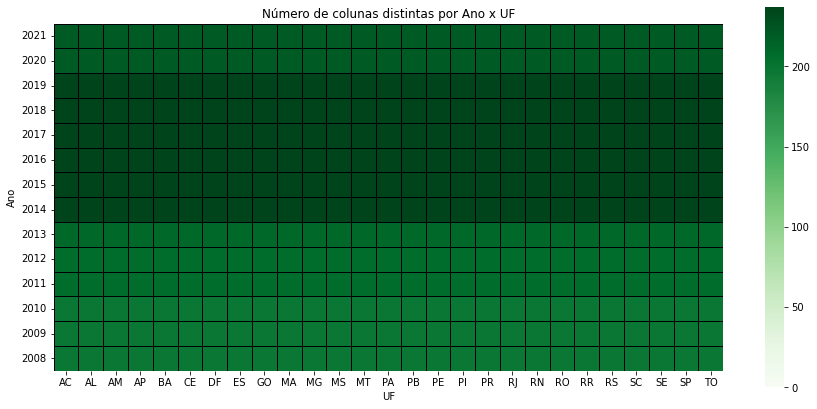

In [6]:
colunas = data_info.ncols_per_year_uf(sihsus)
data_plot.heatmap(colunas, value='colunas distintas')

**Comentários:**
- Não há variação dos valores no eixo x (`UF`);
- Há um crescimento, platô, e declínio do número de variáveis ao crescimento do eixo y (`Ano`);

### Por Ano

<AxesSubplot:xlabel='Ano', ylabel='n_cols'>

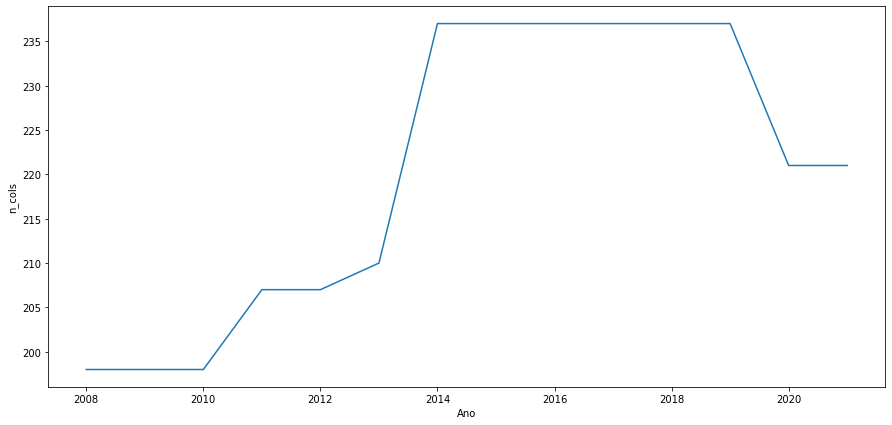

In [7]:
ncols_year = data_info.ncols_per_year(sihsus)
data_plot.line_chart(ncols_year)

**Comentários:**
- A `UF` é independente ao número de colunas, já `Ano` não;
- Até 2014 o número de colunas foi aumentando;
- O número de colunas ficou estável entre 2014 e 2019;
- O número de colunas reduziu em 2020;

**Possíveis investigações:**
- Quais variáveis foram alteradas?

## Quantidade de Registros (linhas)

Foram observados apenas registros cujo o procedimento realizado (variável `PROC_REA`) seja `parto`.

**Sendo os valores:**
- `03.10.01.003-9`: PARTO NORMAL
- `04.11.01.003-4`: PARTO CESARIANO

**Fonte:**
- [SIGTAP/DATASUS](http://sigtap.datasus.gov.br/tabela-unificada/app/sec/inicio.jsp)

### Por Ano x UF

<AxesSubplot:title={'center':'Número de registros por Ano x UF'}, xlabel='UF', ylabel='Ano'>

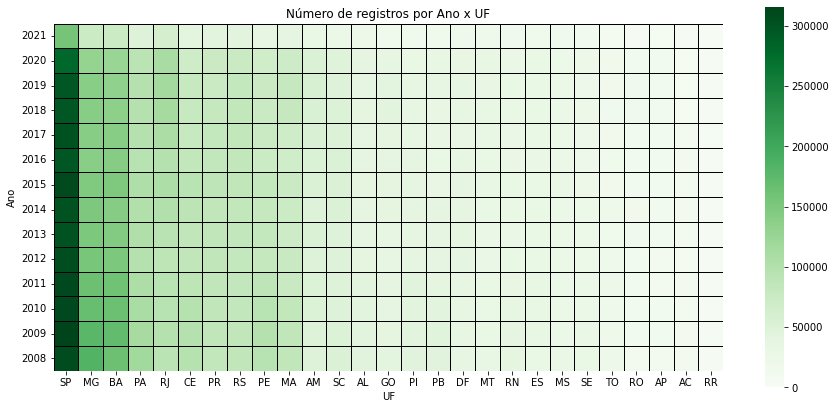

In [8]:
colunas_map = data_info.nrows_per_year_uf(sihsus)
data_plot.heatmap(colunas_map, value='registros')

**Comentários:**

- Estamos visualizando ambos os tipos de partos (`NORMAL` e `CESARIANO`) agregados;
- Estado de São Paulo (`SP`) é notoriamente o que possui maior número de procedimentos de parto;
- `MG`, `BA`, `PA` e `RJ` completam portanto o top 5, respectivamente;

## Tipos de parto

Agora queremos investigar separadamente os tipos de partos:
- `NORMAL`;
- `CESARIANO`;

### Por Ano x UF

Queremos visualizar a proporção que o parto `NORMAL` possui em relação aos partos realizados.

Então para cada célula (`Ano`x`UF`) calculamos:
- `PROPORÇÃO = NORMAL / (NORMAL + CESARIANO)`

<AxesSubplot:title={'center':'Número de proporção de parto normal por Ano x UF'}, xlabel='UF', ylabel='Ano'>

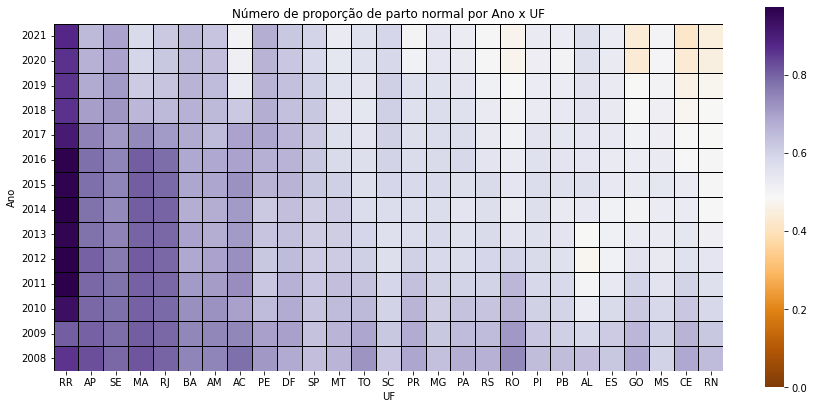

In [9]:
cls_map = data_info.calc_prop(sihsus)
data_plot.heatmap(cls_map, value='proporção de parto normal', cmap='PuOr')

**Comentários:**

- O tipo de parto `NORMAL` é predominante em todo território nacional;
- Estado de Roraima (`RR`) apresenta uma proporção ainda mais destacada para parto `NORMAL`;
- `AP`, `SE`, `MA` E `RJ` completam portanto o top 5 dos estados que mais realizam parto `NORMAL` em relação ao `CESARIANO`, respectivamente;

### Por Ano

Aqui estamos somando os valores de cada `UF` para cada `Ano`.

<AxesSubplot:xlabel='Ano', ylabel='Linhas'>

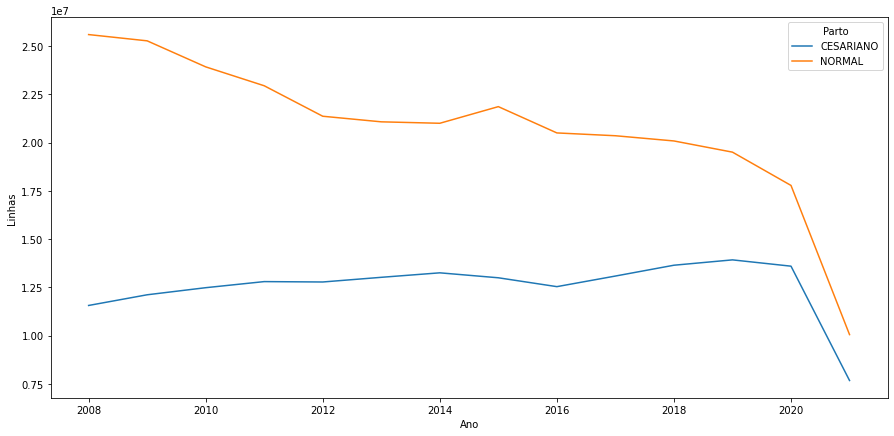

In [10]:
ano_parto_nrows = data_info.n_row_per_year_parto(sihsus)
data_plot.rel_plot(ano_parto_nrows, x='Ano', y='Linhas', hue='Parto')

**Comentários:**

- Realmente parto `NORMAL` é majoritário em relação ao `CESARIANO`;
- Podemos desconsiderar o ano de 2021 pois está incompleto;
- Número de parto do tipo `NORMAL` está em queda;
- Número de parto do tipo `CESARIANO` está em uma leve crescente;

### Por UF

Aqui estamos somando os valores de cada `Ano` para cada `UF`.

<AxesSubplot:xlabel='UF', ylabel='Linhas'>

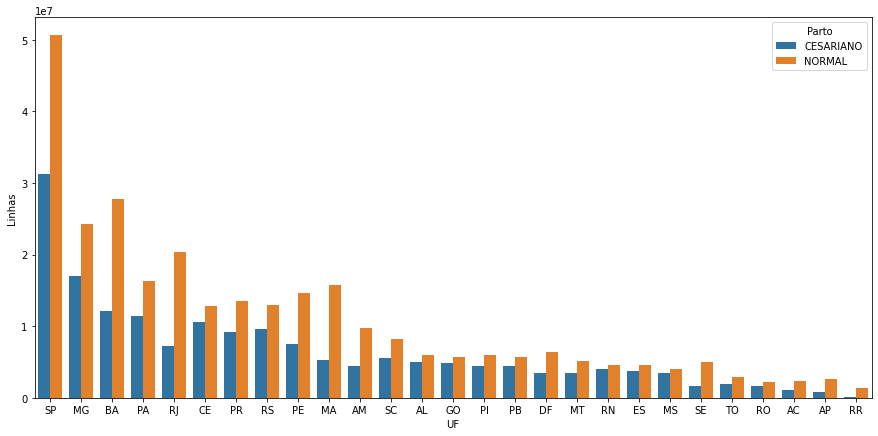

In [11]:
res, ufs_order = data_info.n_rows_per_uf(sihsus)
data_plot.bar_plot(res, ufs_order)

**Comentários:**
- Em todas as `UF`s o tipo de parto `NORMAL` é predominante;

**Possíveis investigações:**
- Ver tipos de partos agrupados por regiões;

## Variáveis de Residência e Internação

Existem variáveis de mesmo nome porém diferenciando o prefixo `res_` e `int_`, indicando o valor referente a `residência` e `internacação` respectivamente.

O objetivo é compararmos se os valores para cada par `res_` e `int_` são diferentes, e assim detectar situações de deslocamento para além da zona residêncial.

Para visualizarmos o impacto que a quantidade de diferentes teve em relação ao total de registros, calculamos a proporção da seguinte forma:
- `PROPORÇÃO = DIFERENTES / LINHAS`

Há 20 pares de variáveis de prefixo `res_` e `int_`, porém, metade delas não são relevantes para comparar os valores visando entender situações de descolamento.

Portanto, vamos analisar os 10 pares relevantes para nossa análise. São eles:

### Variável `REGIAO`

Região do Brasil (Norte, Nordeste, Centro-Oeste, Sudeste, Sul)

In [12]:
var = 'REGIAO'

<AxesSubplot:title={'center':'Número de REGIAO por Ano x UF'}, xlabel='UF', ylabel='Ano'>

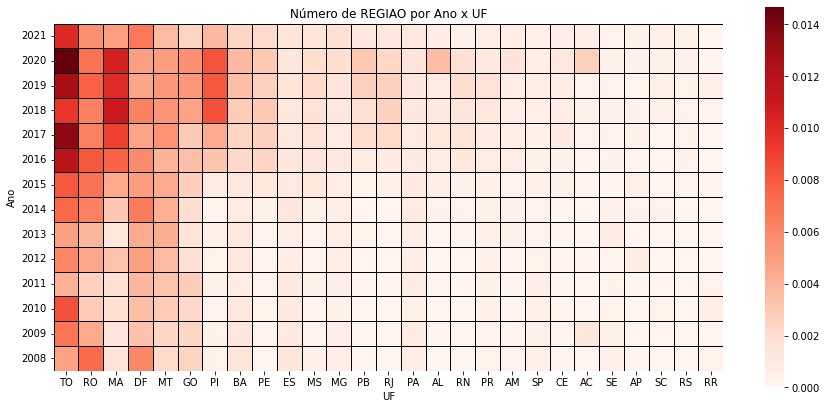

In [13]:
cls_map = data_info.var_diff_per_year_uf(sihsus, var)
data_plot.heatmap(cls_map, value=var, cmap='Reds')

/home/lucas/code/partos/data_info.py:368: RuntimeWarning: invalid value encountered in true_divide
  prop_prop = nor_vals / (nor_vals + ces_vals)


<AxesSubplot:title={'center':'Número de REGIAO por Ano x UF'}, xlabel='UF', ylabel='Ano'>

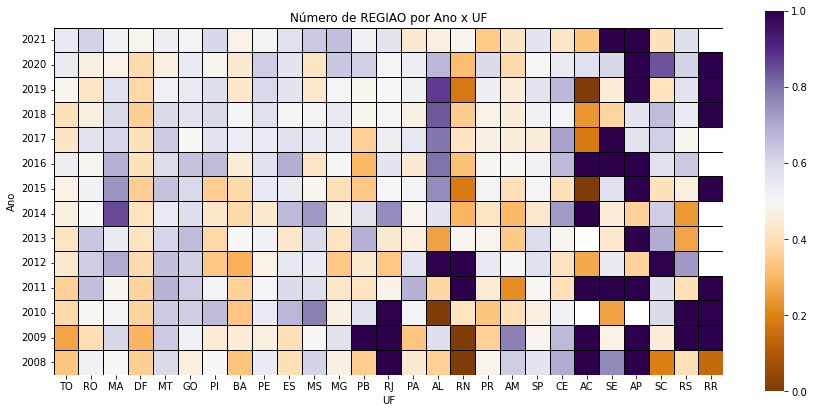

In [14]:
cls_map = data_info.var_prop_per_parto(
    sihsus,
    var,
    ufs_order=cls_map.columns.values,
)
data_plot.heatmap(cls_map, value=var, cmap='PuOr')

### Variável `SIGLA_UF`

Sigla da unidade da federação

In [15]:
var = 'SIGLA_UF'

<AxesSubplot:title={'center':'Número de SIGLA_UF por Ano x UF'}, xlabel='UF', ylabel='Ano'>

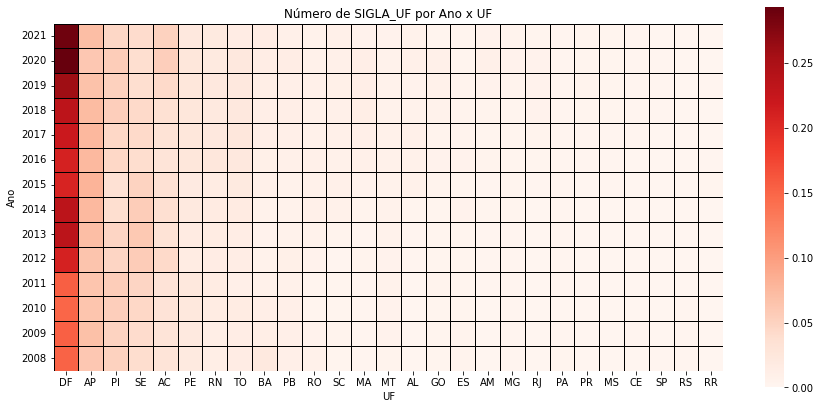

In [16]:
cls_map = data_info.var_diff_per_year_uf(sihsus, var)
data_plot.heatmap(cls_map, value=var, cmap='Reds')

/home/lucas/code/partos/data_info.py:368: RuntimeWarning: invalid value encountered in true_divide
  prop_prop = nor_vals / (nor_vals + ces_vals)


<AxesSubplot:title={'center':'Número de SIGLA_UF por Ano x UF'}, xlabel='UF', ylabel='Ano'>

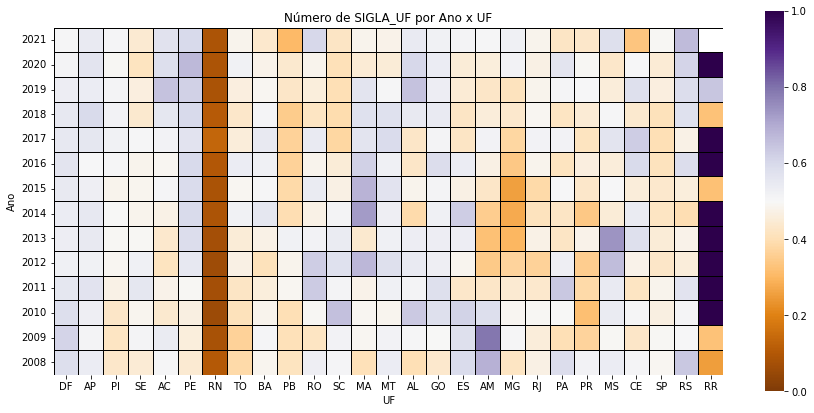

In [17]:
cls_map = data_info.var_prop_per_parto(
    sihsus,
    var,
    ufs_order=cls_map.columns.values,
)
data_plot.heatmap(cls_map, value=var, cmap='PuOr')

### Variável `MSAUDCOD`

Código da Macrorregional de Saúde a que o Município pertence

In [18]:
var = 'MSAUDCOD'

<AxesSubplot:title={'center':'Número de MSAUDCOD por Ano x UF'}, xlabel='UF', ylabel='Ano'>

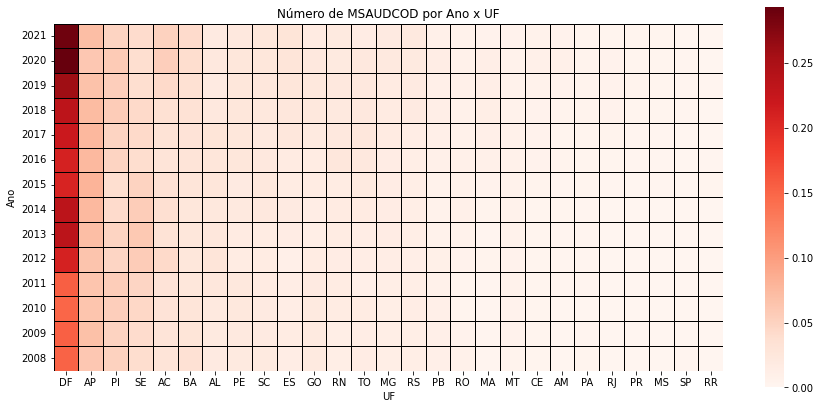

In [19]:
cls_map = data_info.var_diff_per_year_uf(sihsus, var)
data_plot.heatmap(cls_map, value=var, cmap='Reds')

/home/lucas/code/partos/data_info.py:368: RuntimeWarning: invalid value encountered in true_divide
  prop_prop = nor_vals / (nor_vals + ces_vals)


<AxesSubplot:title={'center':'Número de MSAUDCOD por Ano x UF'}, xlabel='UF', ylabel='Ano'>

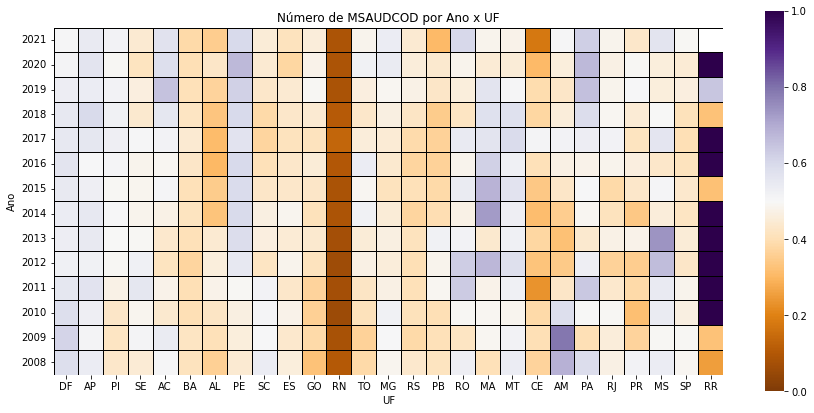

In [20]:
cls_map = data_info.var_prop_per_parto(
    sihsus,
    var,
    ufs_order=cls_map.columns.values,
)
data_plot.heatmap(cls_map, value=var, cmap='PuOr')

### Variável `RSAUDCOD`

Código da Regional de Saúde a que o Município pertence

In [21]:
var = 'RSAUDCOD'

<AxesSubplot:title={'center':'Número de RSAUDCOD por Ano x UF'}, xlabel='UF', ylabel='Ano'>

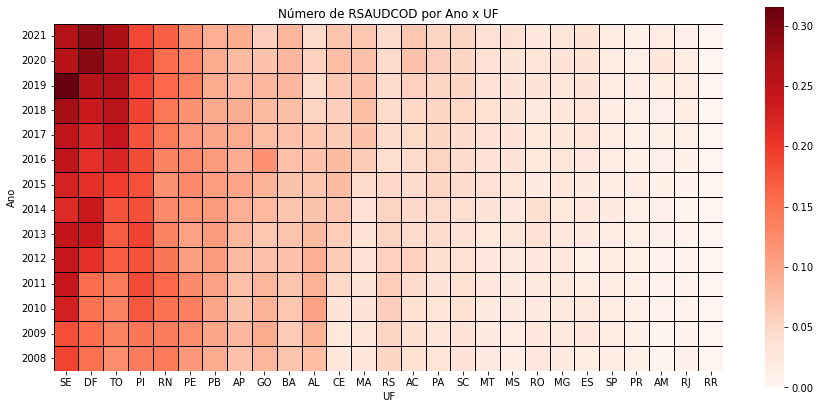

In [22]:
cls_map = data_info.var_diff_per_year_uf(sihsus, var)
data_plot.heatmap(cls_map, value=var, cmap='Reds')

/home/lucas/code/partos/data_info.py:368: RuntimeWarning: invalid value encountered in true_divide
  prop_prop = nor_vals / (nor_vals + ces_vals)


<AxesSubplot:title={'center':'Número de RSAUDCOD por Ano x UF'}, xlabel='UF', ylabel='Ano'>

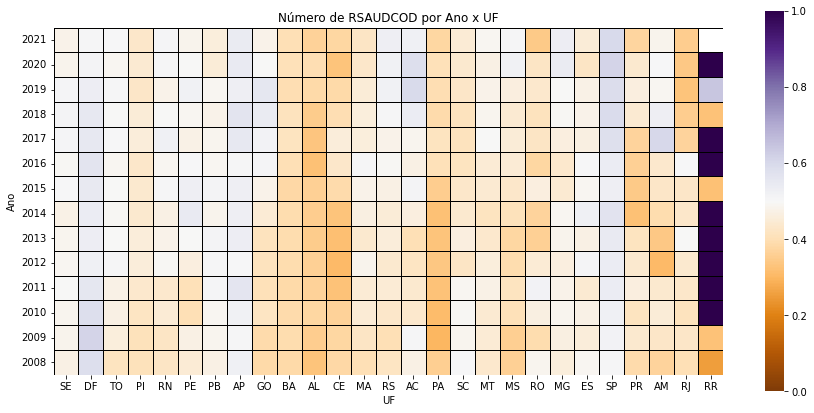

In [23]:
cls_map = data_info.var_prop_per_parto(
    sihsus,
    var,
    ufs_order=cls_map.columns.values,
)
data_plot.heatmap(cls_map, value=var, cmap='PuOr')

### Variável `CSAUDCOD`

Código da Microrregional de Saúde a que o Município pertence

In [24]:
var = 'CSAUDCOD'

<AxesSubplot:title={'center':'Número de CSAUDCOD por Ano x UF'}, xlabel='UF', ylabel='Ano'>

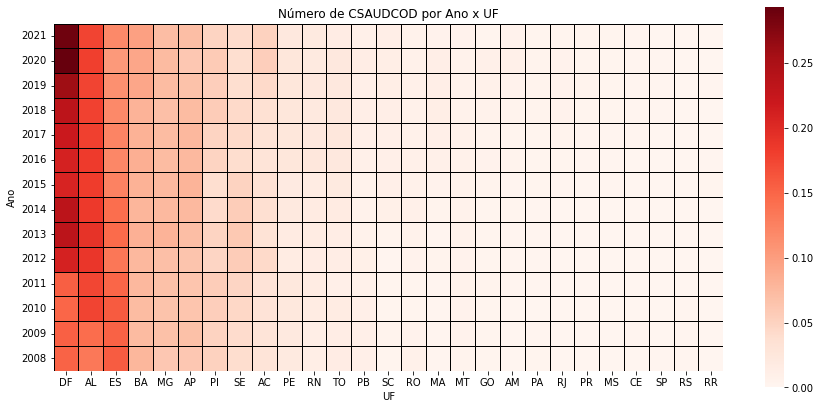

In [25]:
cls_map = data_info.var_diff_per_year_uf(sihsus, var)
data_plot.heatmap(cls_map, value=var, cmap='Reds')

/home/lucas/code/partos/data_info.py:368: RuntimeWarning: invalid value encountered in true_divide
  prop_prop = nor_vals / (nor_vals + ces_vals)


<AxesSubplot:title={'center':'Número de CSAUDCOD por Ano x UF'}, xlabel='UF', ylabel='Ano'>

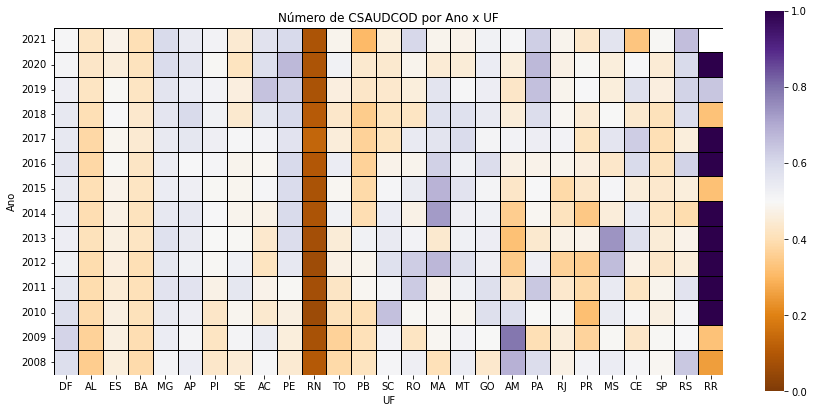

In [26]:
cls_map = data_info.var_prop_per_parto(
    sihsus,
    var,
    ufs_order=cls_map.columns.values,
)
data_plot.heatmap(cls_map, value=var, cmap='PuOr')

### Variável `MUNNOMEX`

Nome (sem acentos, em maiúsculas) do Município

In [27]:
var = 'MUNNOMEX'

<AxesSubplot:title={'center':'Número de MUNNOMEX por Ano x UF'}, xlabel='UF', ylabel='Ano'>

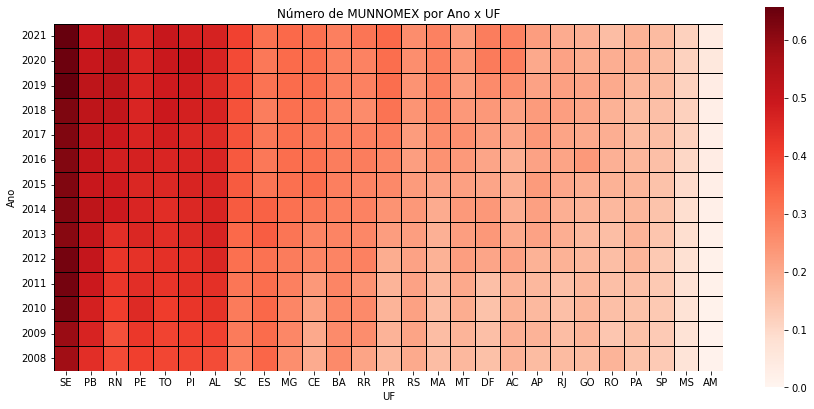

In [28]:
cls_map = data_info.var_diff_per_year_uf(sihsus, var)
data_plot.heatmap(cls_map, value=var, cmap='Reds')

<AxesSubplot:title={'center':'Número de MUNNOMEX por Ano x UF'}, xlabel='UF', ylabel='Ano'>

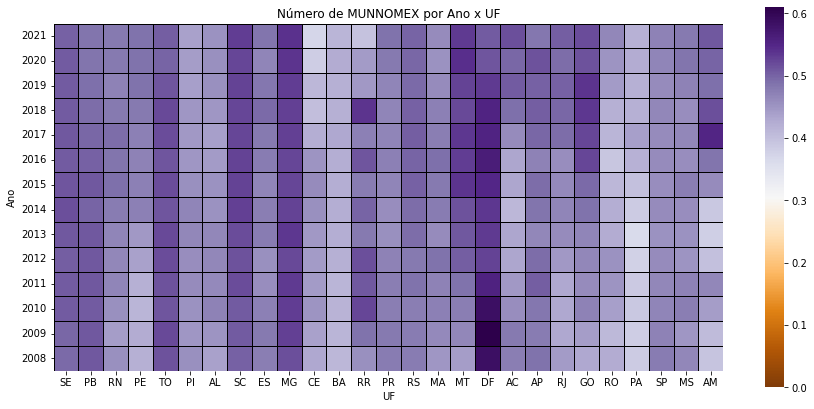

In [29]:
cls_map = data_info.var_prop_per_parto(
    sihsus,
    var,
    ufs_order=cls_map.columns.values,
)
data_plot.heatmap(cls_map, value=var, cmap='PuOr')

### Variável `codigo_adotado`

Armazena o código atribuído ao município, tratando os casos em que múltiplos códigos tenham sido utilizados para um mesmo município ao longo do tempo

In [30]:
var = 'codigo_adotado'

<AxesSubplot:title={'center':'Número de codigo_adotado por Ano x UF'}, xlabel='UF', ylabel='Ano'>

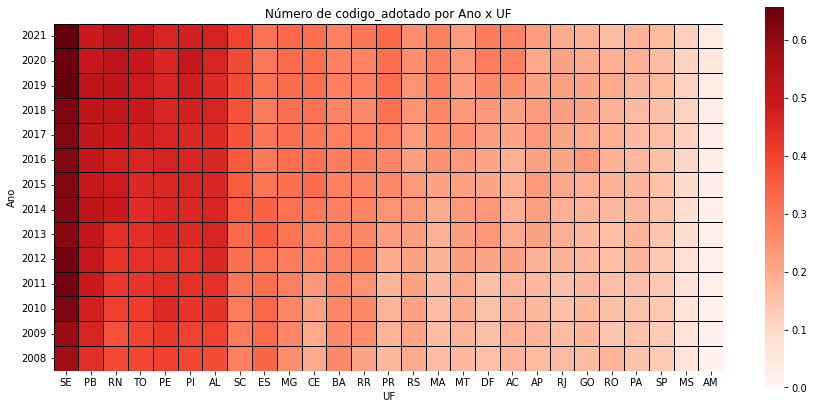

In [31]:
cls_map = data_info.var_diff_per_year_uf(sihsus, var)
data_plot.heatmap(cls_map, value=var, cmap='Reds')

<AxesSubplot:title={'center':'Número de codigo_adotado por Ano x UF'}, xlabel='UF', ylabel='Ano'>

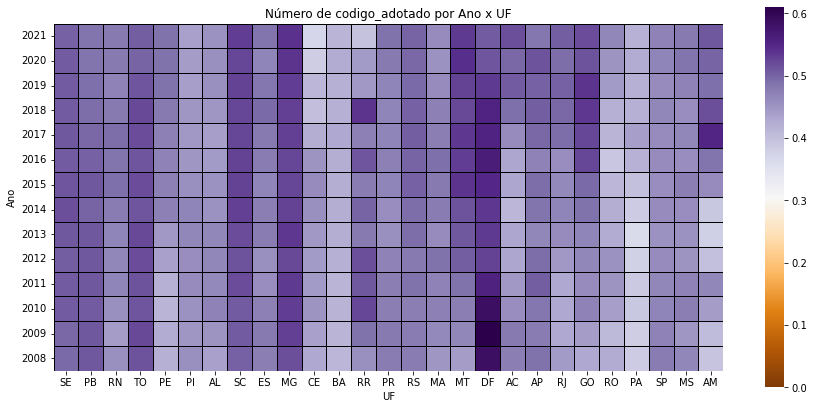

In [32]:
cls_map = data_info.var_prop_per_parto(
    sihsus,
    var,
    ufs_order=cls_map.columns.values,
)
data_plot.heatmap(cls_map, value=var, cmap='PuOr')

### Variável `CAPITAL`

Indica (S ou N) se o município é capital da UF

Diferentes significa quantos links entre capital com demais municípios

In [33]:
var = 'CAPITAL'

<AxesSubplot:title={'center':'Número de CAPITAL por Ano x UF'}, xlabel='UF', ylabel='Ano'>

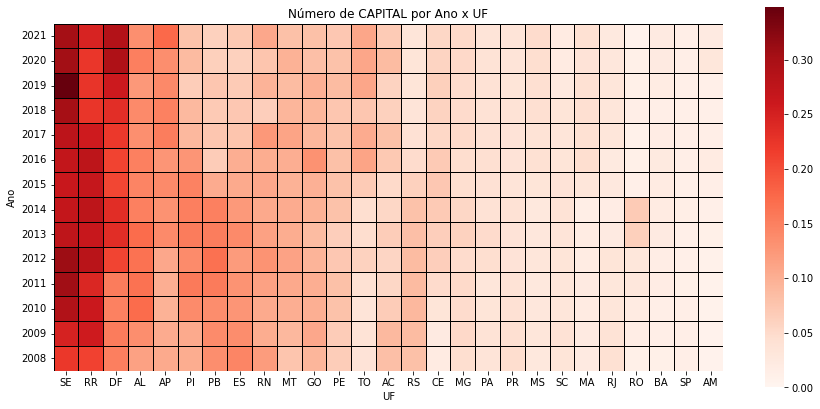

In [34]:
cls_map = data_info.var_diff_per_year_uf(sihsus, var)
data_plot.heatmap(cls_map, value=var, cmap='Reds')

<AxesSubplot:title={'center':'Número de CAPITAL por Ano x UF'}, xlabel='UF', ylabel='Ano'>

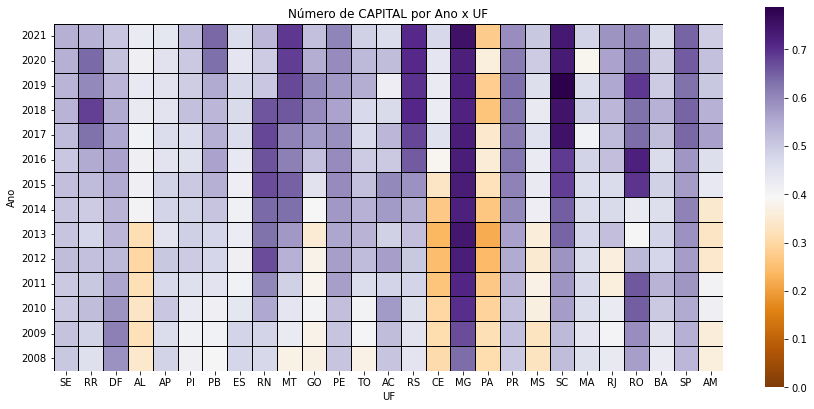

In [35]:
cls_map = data_info.var_prop_per_parto(
    sihsus,
    var,
    ufs_order=cls_map.columns.values,
)
data_plot.heatmap(cls_map, value=var, cmap='PuOr')

### Variável `FRONTEIRA`

Indica (S ou N) se o município faz parte da faixa de fronteira (conforme IBGE)

In [36]:
var = 'FRONTEIRA'

<AxesSubplot:title={'center':'Número de FRONTEIRA por Ano x UF'}, xlabel='UF', ylabel='Ano'>

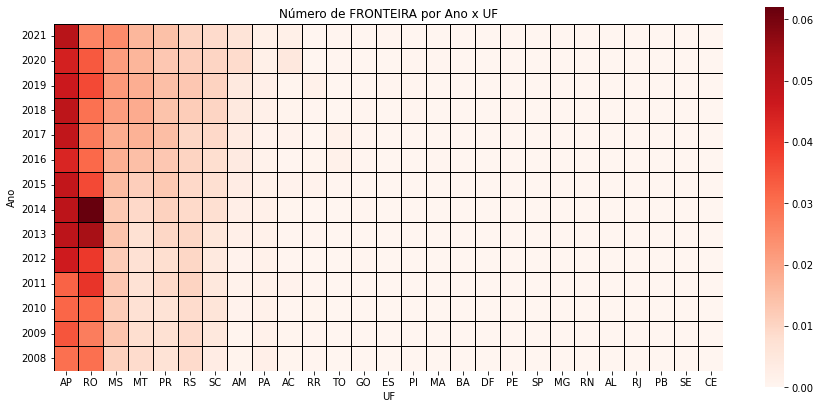

In [37]:
cls_map = data_info.var_diff_per_year_uf(sihsus, var)
data_plot.heatmap(cls_map, value=var, cmap='Reds')

/home/lucas/code/partos/data_info.py:368: RuntimeWarning: invalid value encountered in true_divide
  prop_prop = nor_vals / (nor_vals + ces_vals)


<AxesSubplot:title={'center':'Número de FRONTEIRA por Ano x UF'}, xlabel='UF', ylabel='Ano'>

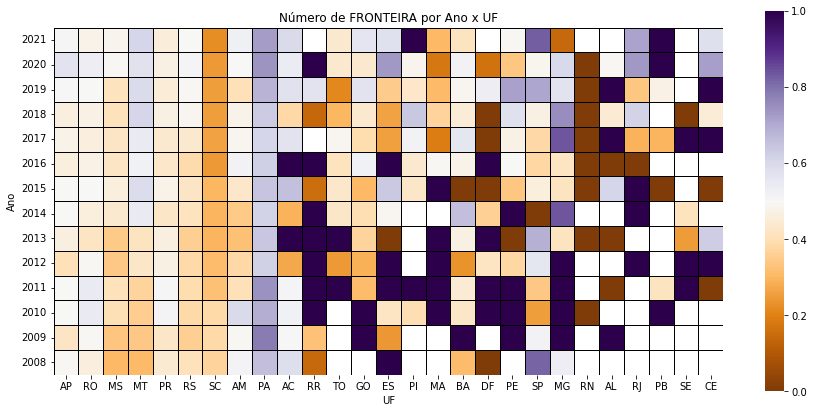

In [38]:
cls_map = data_info.var_prop_per_parto(
    sihsus,
    var,
    ufs_order=cls_map.columns.values,
)
data_plot.heatmap(cls_map, value=var, cmap='PuOr')

### Variável `AMAZONIA`

Indica (S ou N) se o município faz parte da Amazônia Legal (conforme IBGE)

Diferentes significa quantos links entre Amazônia Legal com demais regiões

In [39]:
var = 'AMAZONIA'

<AxesSubplot:title={'center':'Número de AMAZONIA por Ano x UF'}, xlabel='UF', ylabel='Ano'>

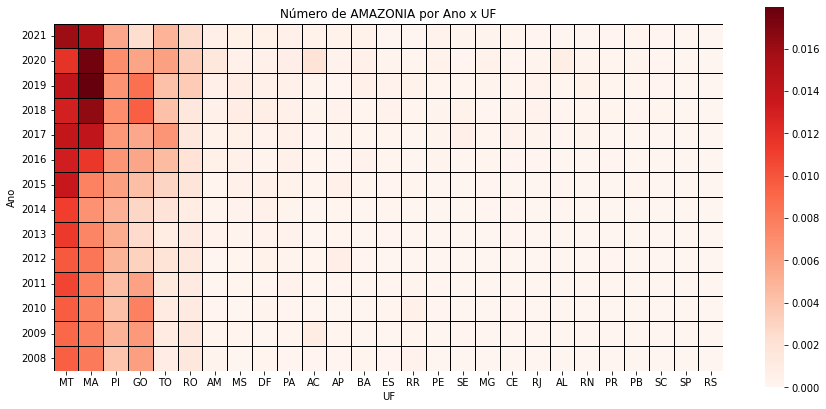

In [40]:
cls_map = data_info.var_diff_per_year_uf(sihsus, var)
data_plot.heatmap(cls_map, value=var, cmap='Reds')

/home/lucas/code/partos/data_info.py:368: RuntimeWarning: invalid value encountered in true_divide
  prop_prop = nor_vals / (nor_vals + ces_vals)


<AxesSubplot:title={'center':'Número de AMAZONIA por Ano x UF'}, xlabel='UF', ylabel='Ano'>

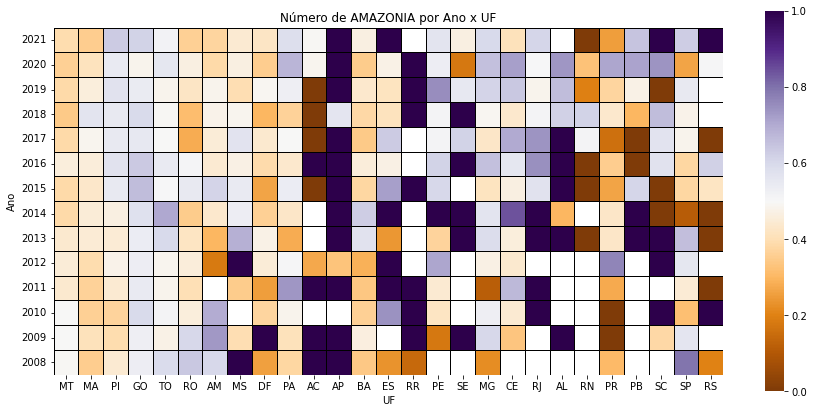

In [41]:
cls_map = data_info.var_prop_per_parto(
    sihsus,
    var,
    ufs_order=cls_map.columns.values,
)
data_plot.heatmap(cls_map, value=var, cmap='PuOr')